In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'  # macOS
plt.rcParams['axes.unicode_minus'] = False

print("라이브러리 로드 완료")

라이브러리 로드 완료


In [25]:
# 데이터 로드
try:
    # 다양한 인코딩 시도
    encodings = ['utf-8', 'cp949', 'euc-kr']
    df = None
    
    for encoding in encodings:
        try:
            df = pd.read_csv('./data/경기도 포천시 유동인구 수.CSV', encoding=encoding)
            print(f"성공: {encoding} 인코딩으로 데이터 로드")
            break
        except UnicodeDecodeError:
            continue
    
    if df is None:
        print("모든 인코딩 시도 실패")
        
except FileNotFoundError:
    print("파일을 찾을 수 없습니다. 파일명을 확인해주세요.")
    print("현재 디렉토리 파일들:")
    import os
    for file in os.listdir('.'):
        if file.endswith('.CSV') or file.endswith('.csv'):
            print(f"  - {file}")

성공: utf-8 인코딩으로 데이터 로드


In [26]:
# 데이터 기본 정보 확인
if df is not None:
    print("=== 데이터 기본 정보 ===")
    print(f"데이터 형태: {df.shape}")
    print(f"컬럼명: {df.columns.tolist()}")
    print("\n=== 데이터 샘플 ===")
    print(df.head())
    print("\n=== 데이터 타입 ===")
    print(df.dtypes)
    print("\n=== 결측값 확인 ===")
    print(df.isnull().sum())
    
    # 김해시 데이터만 필터링
    gimhae_df = df[df['SGG_NM'] == '포천시'].copy()
    print(f"\n=== 포천시 데이터 ===")
    print(f"포천시 데이터 수: {len(gimhae_df)}")
    
    if len(gimhae_df) > 0:
        print("\n=== 포천시 데이터 샘플 ===")
        print(gimhae_df.head())
    else:
        print("포천시 데이터가 없습니다. 시군구명을 확인해주세요.")
        print("고유한 시군구명:", df['SGG_NM'].unique())

=== 데이터 기본 정보 ===
데이터 형태: (11904, 13)
컬럼명: ['\ufeffINDEX_KEY', 'CRTR_YMD', 'CRTR_WEEK', 'DWK_NM', 'CTPV_CD', 'CTPV_NM', 'SGG_CD', 'SGG_NM', 'TMZN_CD', 'SEX_DV', 'AGRDE_CLS', 'REVISN_AMBLT_PUL_CNT', 'REVISN_NMBLT_PUL_CNT']

=== 데이터 샘플 ===
                          ﻿INDEX_KEY  CRTR_YMD  CRTR_WEEK DWK_NM  CTPV_CD  \
0  LI122100010002LI12210001000202331  20201201         49      화       41   
1  LI122100010002LI12210001000202332  20201201         49      화       41   
2  LI122100010002LI12210001000202333  20201201         49      화       41   
3  LI122100010002LI12210001000202334  20201201         49      화       41   
4  LI122100010002LI12210001000202335  20201201         49      화       41   

  CTPV_NM  SGG_CD SGG_NM  TMZN_CD  SEX_DV  AGRDE_CLS  REVISN_AMBLT_PUL_CNT  \
0     경기도    4165    포천시        9  FEMALE          4           4058.975802   
1     경기도    4165    포천시        6    MALE          3           3290.049440   
2     경기도    4165    포천시        3  FEMALE          5           48

In [27]:
# 데이터 전처리 및 분석
if df is not None and len(gimhae_df) > 0:
    # 날짜 변환
    gimhae_df['CRTR_YMD'] = pd.to_datetime(gimhae_df['CRTR_YMD'], format='%Y%m%d')
    gimhae_df['year'] = gimhae_df['CRTR_YMD'].dt.year
    gimhae_df['month'] = gimhae_df['CRTR_YMD'].dt.month
    gimhae_df['day'] = gimhae_df['CRTR_YMD'].dt.day
    
    # 연령대 매핑
    age_mapping = {
        0: '10세미만',
        1: '10대',
        2: '20대',
        3: '30대',
        4: '40대',
        5: '50대',
        6: '60대',
        7: '70대',
        8: '80대이상'
    }
    gimhae_df['연령대명'] = gimhae_df['AGRDE_CLS'].map(age_mapping)
    
    # 총 유동인구 계산 (보행 + 비보행)
    gimhae_df['총유동인구'] = gimhae_df['REVISN_AMBLT_PUL_CNT'] + gimhae_df['REVISN_NMBLT_PUL_CNT']
    
    print("=== 전처리 완료 ===")
    print(f"처리된 데이터 수: {len(gimhae_df)}")
    print(f"기간: {gimhae_df['CRTR_YMD'].min()} ~ {gimhae_df['CRTR_YMD'].max()}")
    print(f"총 유동인구 범위: {gimhae_df['총유동인구'].min():.0f} ~ {gimhae_df['총유동인구'].max():.0f}")

=== 전처리 완료 ===
처리된 데이터 수: 11904
기간: 2020-12-01 00:00:00 ~ 2020-12-31 00:00:00
총 유동인구 범위: 39 ~ 12126


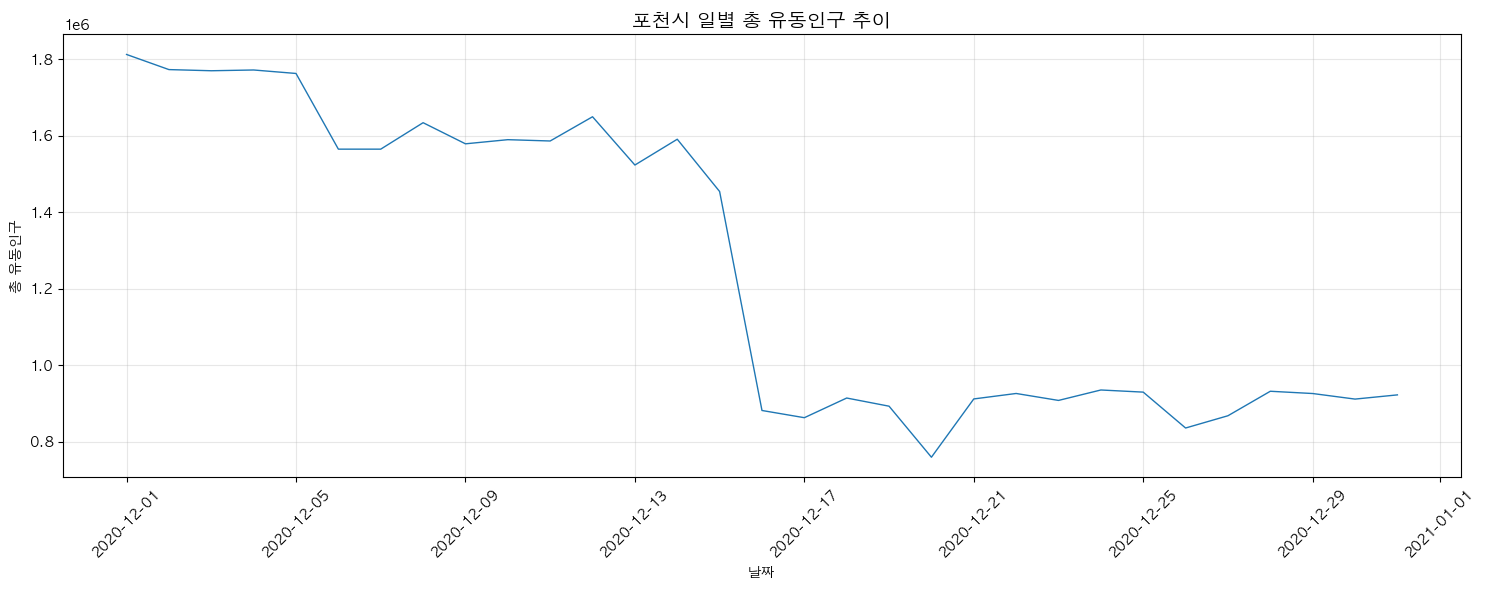

일평균 유동인구: 1255854명
최대 유동인구: 1812112명
최소 유동인구: 758998명


In [28]:
# 1. 일별 총 유동인구 추이
if df is not None and len(gimhae_df) > 0:
    daily_population = gimhae_df.groupby('CRTR_YMD')['총유동인구'].sum().reset_index()
    
    plt.figure(figsize=(15, 6))
    plt.plot(daily_population['CRTR_YMD'], daily_population['총유동인구'], linewidth=1)
    plt.title('포천시 일별 총 유동인구 추이', fontsize=14, fontweight='bold')
    plt.xlabel('날짜')
    plt.ylabel('총 유동인구')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print(f"일평균 유동인구: {daily_population['총유동인구'].mean():.0f}명")
    print(f"최대 유동인구: {daily_population['총유동인구'].max():.0f}명")
    print(f"최소 유동인구: {daily_population['총유동인구'].min():.0f}명")

In [29]:
# 김해시 데이터가 비어있는지 확인
print("포천시 데이터 수:", len(gimhae_df))
print("DWK_NM 고유값:", gimhae_df['DWK_NM'].unique())
print("총유동인구 통계:", gimhae_df['총유동인구'].describe())
print("총유동인구 결측값 수:", gimhae_df['총유동인구'].isnull().sum())
print("총유동인구 0인 행 수:", (gimhae_df['총유동인구'] == 0).sum())
print("요일별 집계 샘플:")
print(gimhae_df.groupby('DWK_NM')['총유동인구'].mean())

포천시 데이터 수: 11904
DWK_NM 고유값: ['화' '수' '목' '금' '토' '일' '월']
총유동인구 통계: count    11904.000000
mean      3270.453770
std       2131.823942
min         39.086437
25%       1662.473104
50%       3033.523998
75%       4559.732495
max      12125.531858
Name: 총유동인구, dtype: float64
총유동인구 결측값 수: 0
총유동인구 0인 행 수: 0
요일별 집계 샘플:
DWK_NM
금    3385.695968
목    3165.628315
수    3151.459073
월    3253.847922
일    3069.012814
토    3346.027595
화    3516.058549
Name: 총유동인구, dtype: float64


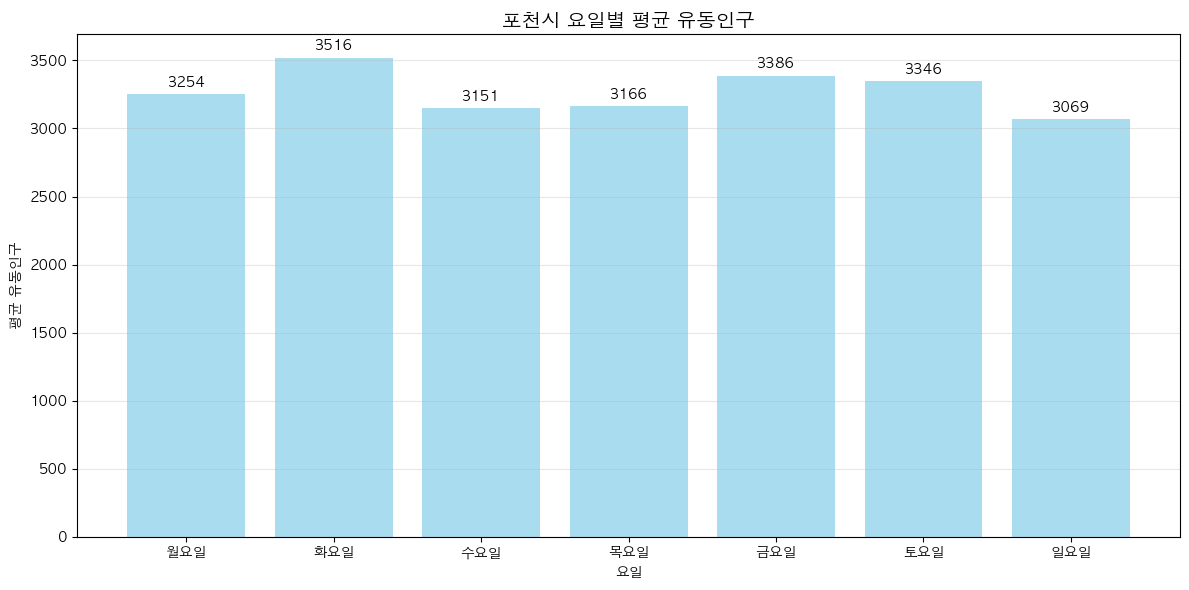

In [30]:
# 2. 요일별 유동인구 패턴 (한글 요일 코드용)
if df is not None and len(gimhae_df) > 0:
    weekday_population = gimhae_df.groupby('DWK_NM')['총유동인구'].mean().reset_index()
    
    # 한글 요일 순서
    weekday_order = ['월', '화', '수', '목', '금', '토', '일']
    weekday_names = ['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']
    
    # 요일명 매핑
    weekday_population['요일명'] = weekday_population['DWK_NM'].map(dict(zip(weekday_order, weekday_names)))
    
    # 요일 순서대로 정렬
    weekday_population['요일순서'] = weekday_population['DWK_NM'].map({day: i for i, day in enumerate(weekday_order)})
    weekday_population = weekday_population.sort_values('요일순서')
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(weekday_population['요일명'], weekday_population['총유동인구'], 
                   color='skyblue', alpha=0.7)
    plt.title('포천시 요일별 평균 유동인구', fontsize=14, fontweight='bold')
    plt.xlabel('요일')
    plt.ylabel('평균 유동인구')
    plt.grid(True, alpha=0.3, axis='y')
    
    # 값 표시
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{height:.0f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

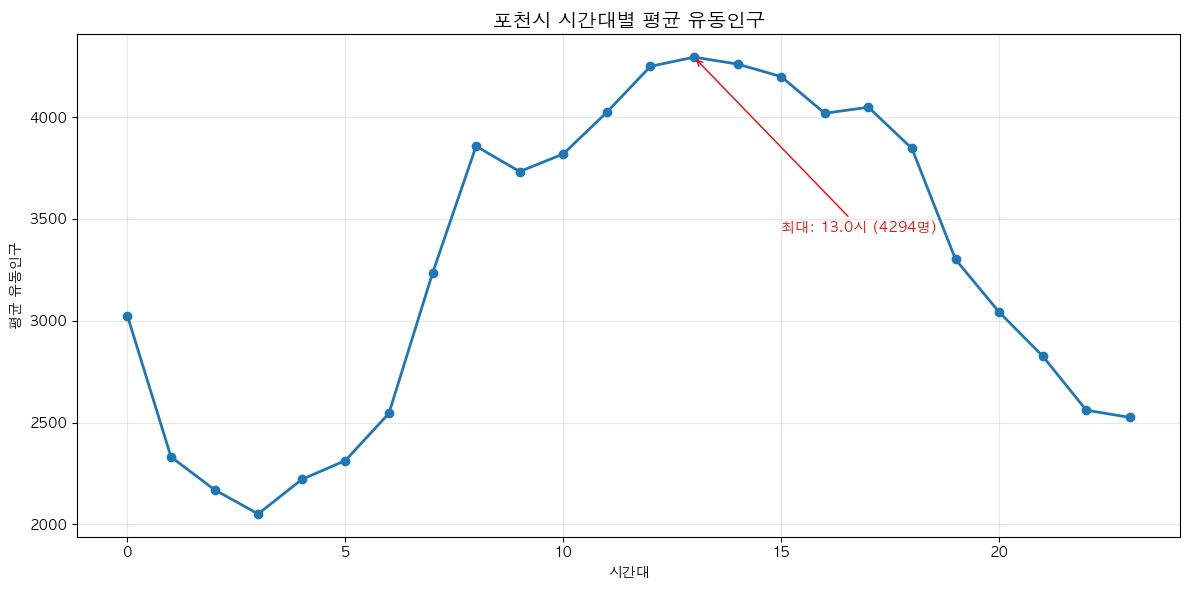

In [31]:
# 3. 시간대별 유동인구 패턴
if df is not None and len(gimhae_df) > 0:
    hourly_population = gimhae_df.groupby('TMZN_CD')['총유동인구'].mean().reset_index()
    
    plt.figure(figsize=(12, 6))
    plt.plot(hourly_population['TMZN_CD'], hourly_population['총유동인구'], 
             marker='o', linewidth=2, markersize=6)
    plt.title('포천시 시간대별 평균 유동인구', fontsize=14, fontweight='bold')
    plt.xlabel('시간대')
    plt.ylabel('평균 유동인구')
    plt.grid(True, alpha=0.3)
    
    # 피크 시간 표시
    peak_hour = hourly_population.loc[hourly_population['총유동인구'].idxmax()]
    plt.annotate(f'최대: {peak_hour["TMZN_CD"]}시 ({peak_hour["총유동인구"]:.0f}명)',
                xy=(peak_hour['TMZN_CD'], peak_hour['총유동인구']),
                xytext=(peak_hour['TMZN_CD']+2, peak_hour['총유동인구']*0.8),
                arrowprops=dict(arrowstyle='->', color='red'),
                fontsize=10, color='red', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

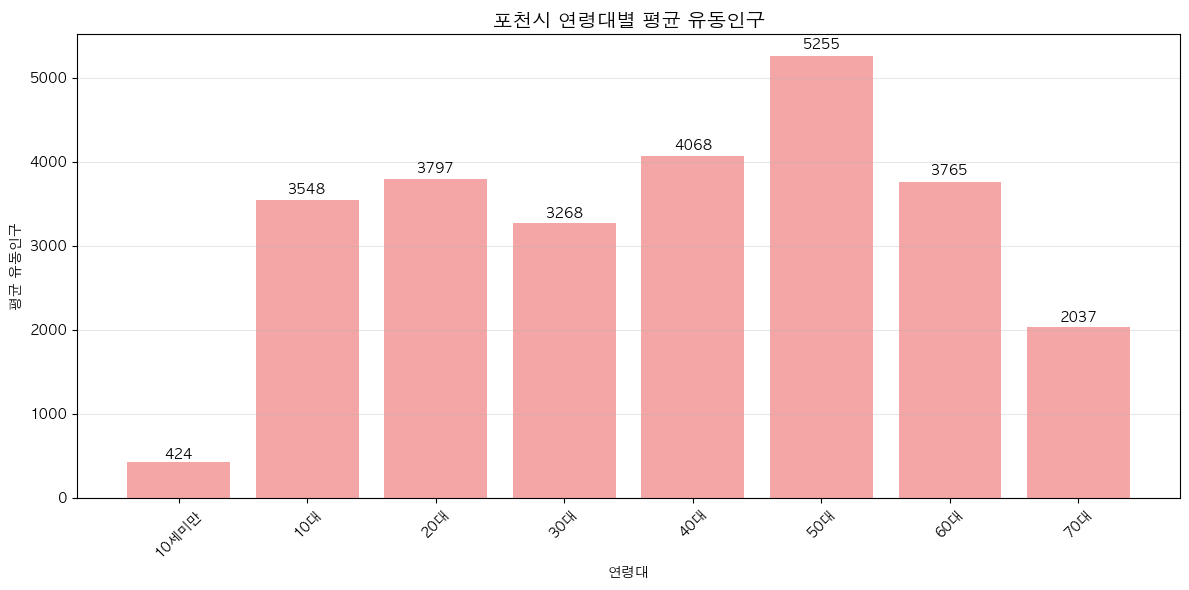

In [32]:
# 4. 연령대별 유동인구 분포
if df is not None and len(gimhae_df) > 0:
    age_population = gimhae_df.groupby('연령대명')['총유동인구'].mean().reset_index()
    
    # 연령대 순서 정렬
    age_order = ['10세미만', '10대', '20대', '30대', '40대', '50대', '60대', '70대', '80대이상']
    age_population['연령대명'] = pd.Categorical(age_population['연령대명'], categories=age_order, ordered=True)
    age_population = age_population.sort_values('연령대명')
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(age_population['연령대명'], age_population['총유동인구'], 
                   color='lightcoral', alpha=0.7)
    plt.title('포천시 연령대별 평균 유동인구', fontsize=14, fontweight='bold')
    plt.xlabel('연령대')
    plt.ylabel('평균 유동인구')
    plt.grid(True, alpha=0.3, axis='y')
    plt.xticks(rotation=45)
    
    # 값 표시
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{height:.0f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

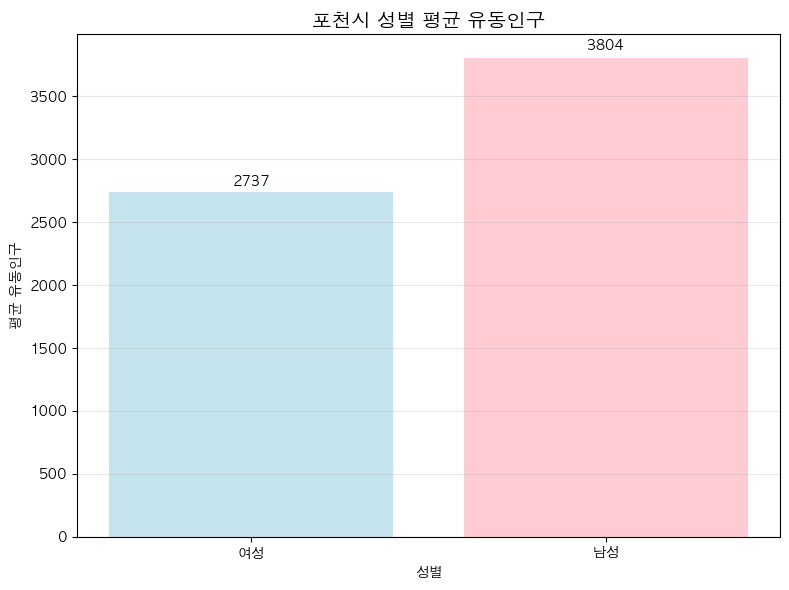

여성: 2737명 (41.8%)
남성: 3804명 (58.2%)


In [33]:
# 5. 성별 유동인구 비교
if df is not None and len(gimhae_df) > 0:
    gender_population = gimhae_df.groupby('SEX_DV')['총유동인구'].mean().reset_index()
    gender_population['성별명'] = gender_population['SEX_DV'].map({'MALE': '남성', 'FEMALE': '여성'})
    
    plt.figure(figsize=(8, 6))
    colors = ['lightblue', 'lightpink']
    bars = plt.bar(gender_population['성별명'], gender_population['총유동인구'], 
                   color=colors, alpha=0.7)
    plt.title('포천시 성별 평균 유동인구', fontsize=14, fontweight='bold')
    plt.xlabel('성별')
    plt.ylabel('평균 유동인구')
    plt.grid(True, alpha=0.3, axis='y')
    
    # 값 표시
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{height:.0f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # 성별 비율 계산
    total = gender_population['총유동인구'].sum()
    for _, row in gender_population.iterrows():
        ratio = (row['총유동인구'] / total) * 100
        print(f"{row['성별명']}: {row['총유동인구']:.0f}명 ({ratio:.1f}%)")

In [34]:
print("TMZN_CD 컬럼 존재 여부:", 'TMZN_CD' in gimhae_df.columns)
print("TMZN_CD 고유값:", gimhae_df['TMZN_CD'].unique() if 'TMZN_CD' in gimhae_df.columns else "없음")
print("TMZN_CD 결측값 수:", gimhae_df['TMZN_CD'].isnull().sum() if 'TMZN_CD' in gimhae_df.columns else "없음")

TMZN_CD 컬럼 존재 여부: True
TMZN_CD 고유값: [ 9  6  3 22  1  7  2 20 11 13 21 10  0 15  4 23 18 12 19 17 16  5  8 14]
TMZN_CD 결측값 수: 0


In [35]:
if 'TMZN_CD' in gimhae_df.columns:
    print(gimhae_df['TMZN_CD'].head(10))
    print(gimhae_df['TMZN_CD'].dtype)

0     9
1     6
2     3
3    22
4     1
5     7
6     2
7    20
8     9
9    11
Name: TMZN_CD, dtype: int64
int64


In [36]:
if 'TMZN_CD' in gimhae_df.columns:
    print(gimhae_df[gimhae_df['TMZN_CD'].isnull()])
    print(gimhae_df[gimhae_df['TMZN_CD'] == ''])

Empty DataFrame
Columns: [﻿INDEX_KEY, CRTR_YMD, CRTR_WEEK, DWK_NM, CTPV_CD, CTPV_NM, SGG_CD, SGG_NM, TMZN_CD, SEX_DV, AGRDE_CLS, REVISN_AMBLT_PUL_CNT, REVISN_NMBLT_PUL_CNT, year, month, day, 연령대명, 총유동인구]
Index: []
Empty DataFrame
Columns: [﻿INDEX_KEY, CRTR_YMD, CRTR_WEEK, DWK_NM, CTPV_CD, CTPV_NM, SGG_CD, SGG_NM, TMZN_CD, SEX_DV, AGRDE_CLS, REVISN_AMBLT_PUL_CNT, REVISN_NMBLT_PUL_CNT, year, month, day, 연령대명, 총유동인구]
Index: []


In [37]:
print(gimhae_df.columns.tolist())

['\ufeffINDEX_KEY', 'CRTR_YMD', 'CRTR_WEEK', 'DWK_NM', 'CTPV_CD', 'CTPV_NM', 'SGG_CD', 'SGG_NM', 'TMZN_CD', 'SEX_DV', 'AGRDE_CLS', 'REVISN_AMBLT_PUL_CNT', 'REVISN_NMBLT_PUL_CNT', 'year', 'month', 'day', '연령대명', '총유동인구']


In [38]:
# 혹시 모를 공백/특수문자 제거
gimhae_df['DWK_NM'] = gimhae_df['DWK_NM'].astype(str).str.strip()

# 한글 요일명 매핑
weekday_map = {'월': '월', '화': '화', '수': '수', '목': '목', '금': '금', '토': '토', '일': '일'}
gimhae_df['요일명'] = gimhae_df['DWK_NM'].map(weekday_map)

print(gimhae_df[['DWK_NM', '요일명']].head(10))
print("요일명 고유값:", gimhae_df['요일명'].unique())

  DWK_NM 요일명
0      화   화
1      화   화
2      화   화
3      화   화
4      화   화
5      화   화
6      화   화
7      화   화
8      화   화
9      화   화
요일명 고유값: ['화' '수' '목' '금' '토' '일' '월']


In [39]:
# 6. 요일별 시간대별 히트맵
"""
if df is not None and len(gimhae_df) > 0:
    # 요일명 매핑
    weekday_names = {'Y': '일', 'M': '월', 'T': '화', 'W': '수', 'T': '목', 'F': '금', 'S': '토'}
    gimhae_df['요일명'] = gimhae_df['DWK_NM'].map(weekday_names)
    
    # 피벗 테이블 생성
    heatmap_data = gimhae_df.pivot_table(
        values='총유동인구', 
        index='요일명', 
        columns='TMZN_CD', 
        aggfunc='mean'
    )
    
    # 요일 순서 정렬
    weekday_order = ['일', '월', '화', '수', '목', '금', '토']
    heatmap_data = heatmap_data.reindex(weekday_order)
    
    plt.figure(figsize=(15, 8))
    sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlOrRd', cbar_kws={'label': '평균 유동인구'})
    plt.title('포천시 요일별 시간대별 평균 유동인구 히트맵', fontsize=14, fontweight='bold')
    plt.xlabel('시간대')
    plt.ylabel('요일')
    plt.tight_layout()
    plt.show()
"""

"\nif df is not None and len(gimhae_df) > 0:\n    # 요일명 매핑\n    weekday_names = {'Y': '일', 'M': '월', 'T': '화', 'W': '수', 'T': '목', 'F': '금', 'S': '토'}\n    gimhae_df['요일명'] = gimhae_df['DWK_NM'].map(weekday_names)\n\n    # 피벗 테이블 생성\n    heatmap_data = gimhae_df.pivot_table(\n        values='총유동인구', \n        index='요일명', \n        columns='TMZN_CD', \n        aggfunc='mean'\n    )\n\n    # 요일 순서 정렬\n    weekday_order = ['일', '월', '화', '수', '목', '금', '토']\n    heatmap_data = heatmap_data.reindex(weekday_order)\n\n    plt.figure(figsize=(15, 8))\n    sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlOrRd', cbar_kws={'label': '평균 유동인구'})\n    plt.title('포천시 요일별 시간대별 평균 유동인구 히트맵', fontsize=14, fontweight='bold')\n    plt.xlabel('시간대')\n    plt.ylabel('요일')\n    plt.tight_layout()\n    plt.show()\n"

In [40]:
print(gimhae_df[['CRTR_YMD', 'year', 'month']].head(20))
print("year 고유값:", gimhae_df['year'].unique())
print("month 고유값:", gimhae_df['month'].unique())
print("monthly_population shape:", monthly_population.shape)
print(monthly_population)

     CRTR_YMD  year  month
0  2020-12-01  2020     12
1  2020-12-01  2020     12
2  2020-12-01  2020     12
3  2020-12-01  2020     12
4  2020-12-01  2020     12
5  2020-12-01  2020     12
6  2020-12-01  2020     12
7  2020-12-01  2020     12
8  2020-12-01  2020     12
9  2020-12-01  2020     12
10 2020-12-01  2020     12
11 2020-12-01  2020     12
12 2020-12-01  2020     12
13 2020-12-01  2020     12
14 2020-12-01  2020     12
15 2020-12-01  2020     12
16 2020-12-01  2020     12
17 2020-12-01  2020     12
18 2020-12-01  2020     12
19 2020-12-01  2020     12
year 고유값: [2020]
month 고유값: [12]


NameError: name 'monthly_population' is not defined

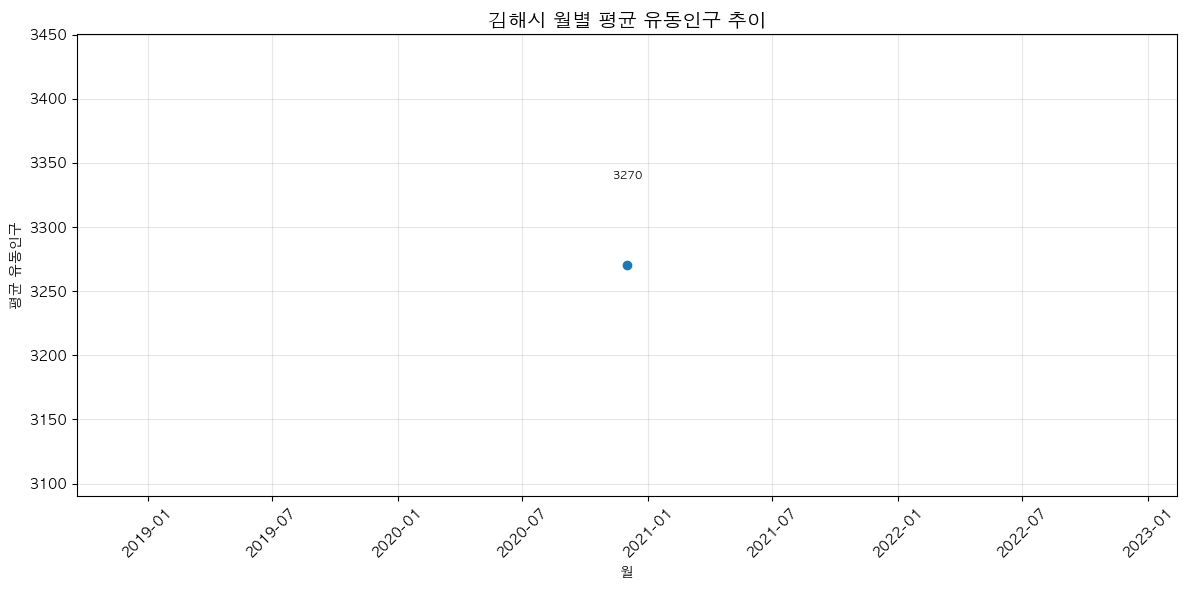

In [41]:
# 7. 월별 유동인구 추이
if df is not None and len(gimhae_df) > 0:
    monthly_population = gimhae_df.groupby(['year', 'month'])['총유동인구'].mean().reset_index()
    monthly_population['날짜'] = pd.to_datetime(monthly_population[['year', 'month']].assign(day=1))
    
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_population['날짜'], monthly_population['총유동인구'], 
             marker='o', linewidth=2, markersize=6)
    plt.title('김해시 월별 평균 유동인구 추이', fontsize=14, fontweight='bold')
    plt.xlabel('월')
    plt.ylabel('평균 유동인구')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # 값 표시
    for _, row in monthly_population.iterrows():
        plt.text(row['날짜'], row['총유동인구'] + row['총유동인구']*0.02,
                f'{row["총유동인구"]:.0f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()

In [ ]:
# 8. 데이터 요약 통계
if df is not None and len(gimhae_df) > 0:
    print("=== 김해시 유동인구 데이터 요약 ===")
    print(f"데이터 기간: {gimhae_df['CRTR_YMD'].min().strftime('%Y-%m-%d')} ~ {gimhae_df['CRTR_YMD'].max().strftime('%Y-%m-%d')}")
    print(f"총 데이터 수: {len(gimhae_df):,}개")
    print(f"일평균 유동인구: {gimhae_df.groupby('CRTR_YMD')['총유동인구'].sum().mean():.0f}명")
    print(f"시간대별 평균 유동인구: {gimhae_df.groupby('TMZN_CD')['총유동인구'].mean().max():.0f}명 (최대)")
    
    # 가장 활발한 시간대
    peak_hour = gimhae_df.groupby('TMZN_CD')['총유동인구'].mean().idxmax()
    print(f"가장 활발한 시간대: {peak_hour}시")
    
    # 가장 활발한 요일
    weekday_names = {'Y': '일요일', 'M': '월요일', 'T': '화요일', 'W': '수요일', 'T': '목요일', 'F': '금요일', 'S': '토요일'}
    peak_weekday = gimhae_df.groupby('DWK_NM')['총유동인구'].mean().idxmax()
    print(f"가장 활발한 요일: {weekday_names[peak_weekday]}")
    
    # 가장 많은 연령대
    peak_age = gimhae_df.groupby('연령대명')['총유동인구'].mean().idxmax()
    print(f"가장 많은 연령대: {peak_age}")
    
    print("\n=== 데이터 품질 평가 ===")
    print(f"결측값: {gimhae_df.isnull().sum().sum()}개")
    print(f"중복값: {gimhae_df.duplicated().sum()}개")
    print(f"음수값: {(gimhae_df['총유동인구'] < 0).sum()}개")
    
    if gimhae_df.isnull().sum().sum() == 0 and gimhae_df.duplicated().sum() == 0:
        print("✅ 데이터 품질이 양호합니다.")
    else:
        print("⚠️ 데이터 품질에 문제가 있을 수 있습니다.")